# <center> Gradient-based optimization of Neural Networks </center>

<center> Krishna Pillutla, Vincent Roulet, Zaid Harchaoui  
University of Washington  
{pillutla, vroulet, zaid} @ uw.edu  
    July 28, 2018
    </center>
 
**Acknowledgements** This work was supported by the NSF TRIPODS Award (CCF-1740551).

In this lab, we will present and compare standard methods for gradient-based optimization of deep neural networks using [PyTorch](https://pytorch.org/).

Beyond the practical tools presented in this lab, other takeaways from this lab are:
* Why stochastic gradient descent is preferred over gradient descent
* Theoretical guarantees and practical heuristics for the stochastic gradient descent
* How simple stochastic gradient descent compares to various "adaptive" methods
* How batch normalization helps the optimization of neural networks


Notes on this lab are available to better understand basic theoretical concepts on optimization. In particular, rates of convergence of gradient and stochastic gradient descent are reviewed. Note that no such result exists for Adam, a popular adaptive method used as an alternative to stochastic gradient descent.

***References:***

For more details about optimization of deep neural networks, read [Lecun et al](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), [Bottou](https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf) or [this book](https://www.springer.com/la/book/9783642352881) compiling tricks for optimization of deep neural networks. 
The comparison between classical stochastic gradient descent and "adaptive" methods is inspired from [Wilson et al](https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf).
For more details about batch normalization, see the original paper by [Ioffe and Szegedy 2015](https://arxiv.org/abs/1502.03167).

In [1]:
import numpy as np
import os, sys, time, pickle
from argparse import Namespace
from copy import deepcopy
from argparse import Namespace

# PATH + local imports
sys.path.append(os.path.join(sys.path[0],'codes'))
import my_cifar_dataset, my_mnist_dataset

# torch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, softplus, dropout
import torch.optim as optim

from curv import compute_curv
import plot_helper

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# datasets
ds = torchvision.datasets.CIFAR10(root='./data/CIFAR', download=True)
ds = torchvision.datasets.MNIST(root='./data/MNIST', download=True)

Files already downloaded and verified


## Neural networks 

The goal of supervised learning is to find a mapping $\Phi$ from inputs $x\in \mathcal{X}$ to outputs $y \in \mathcal{Y}$ given a set of training examples $(x_1, y_1), \ldots, (x_n,y_n) \in \mathcal{X} \times \mathcal{Y}$. Typically, inputs are $d$-dimensional vectors $\mathcal{X} = \mathbb{R}^d$ and outputs are categorical, encoded by binary vectors $\mathcal{Y} =\{0,1\}^K$ for $K$-class classification or the quantitative measure $\mathcal{Y} = \mathbb{R}$ for regression. Neural network methods parametrize these mappings $\Phi:\mathcal{X} \mapsto \mathcal{Y}$ by successive compositions of linear transformations followed by non-linear ones.

### Definition

Formally, neural networks are composed of $L$ layers. 
The affine mapping at the $l^{\mathrm{th}}$ layer
is parameterized by the  weights-bias pair $u_l = (W_l, b_l)$. 
The complete mapping is then a function of $u = (u_1,\ldots,u_L)$  given by
$$
\Phi(x;u) = \phi_{u_{L}}\circ \phi_{u_{L-1}} \circ \ldots \circ \phi_{u_{1}}(x),
$$
where, for any $l = 1,\ldots, L$,
$$
\phi_{u_l}(x) =  \sigma(W_l x +b_l),
$$
and $\sigma$ is a non-linear operation such as the point-wise application of the 
soft-plus function $\log(1+\exp(\beta x))/\beta$ displayed below, where $\beta$ is a parameter that shapes the function (see [here](https://pytorch.org/docs/stable/nn.html#softplus) for more details)

<center><img src="img/Softplus.png" width="400" align="center"/></center>

The following scheme ([source](https://www.intechopen.com/books/metallurgy-advances-in-materials-and-processes/artificial-intelligence-techniques-for-modelling-of-temperature-in-the-metal-cutting-process)) illustrates the formal definition 

<center><img src="img/neural_net.png" width="400" align="center"/></center>

On an input-output pair $(x,y)$, the error of prediction of $y$ by $\Phi(x;u)$ is measured by a loss $\ell(y, \Phi(x;u))$ such as the squared loss, $\ell_2(y,\Phi(x;u))=\frac{1}{2} \|y-\Phi(x;u)\|_2^2$ or logistic loss and the learning procedure consists of minimizing the empirical loss on the set of input-output training examples $(x_1,y_1),\ldots,(x_n,y_n)$ leading to the optimization problem
$$
   \min_{\substack{u = (u_1,\ldots,u_L)}} \quad \frac{1}{n} \sum_{i=1}^n \ell(y_i,\Phi(x_i;u)).
$$

### Initiate a simple network
A neural network can easily be defined using the framework provided by [PyTorch](https://pytorch.org/). There, a network is an object defined by
* the affine transformations parameterized by $u_1,\ldots,u_L$ above, that are the attributes of the network , through the constructor `__init__`,
* the whole operations made on an input by the network, i.e. the function $\Phi$ defined above, (so composing the linear transformations with non-linear ones), through the function <code>forward</code>.

We will see different linear and non-linear operations in this lab. For the moment we will just use the ones presented before, i.e. affine transformation and the softplus function.

To begin with, we will define a simple Multi-Layer Perceptron (MLP) for images with two layers, i.e. parameterized by two linear transformations ($u_1, u_2$). The Mapping $\Phi$ will then reduce the input (in this case, an image) to a vector, apply the first affine map (such a layer is called fully connected (fc below)), then the soft-plus function as the non-linearity $\sigma$ and finally apply the second affine map.

Below is the code in PyTorch to define this MLP:

In [2]:
class MLPNet(nn.Module):
    """
    Simple multi-layer perceptron (MLP) with one hidden layer
    """
    def __init__(self, size_img, num_hidden_nodes, num_classes):
        super(MLPNet, self).__init__()
        # First linear map form the space of images represented by 
        # vectors of size size_img to the dimension of the first layer
        self.size_img = size_img
        self.fc1 = nn.Linear(size_img, num_hidden_nodes)
        # Second linear map from output of layer 1 to the output space (here composed of num_classes)
        self.fc2 = nn.Linear(num_hidden_nodes, num_classes)
        # Define the non-linearity
        # threshold parameter is properly defined in pytorch manual
        self.nonlin = lambda x: softplus(x, beta=25, threshold=1)
        # self.nonlin = relu # uncomment to use ReLu instead
    def forward(self, x):
        # Reduce image to a vector:
        x = x.view(-1, self.size_img)
        # Apply first linear map followed by the non-linearity
        x = self.nonlin(self.fc1(x))
        # Apply the second linear map
        x = self.fc2(x)
        return x

We will use this network to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (see examples of data [here](https://oriamathematics.wordpress.com/2016/08/12/binary-classification-with-logistic-regression/)). These are 28x28 images  of digits 0,...,9 (10 classes) represented by a one-hot encoding. That is, image $x_i \in \mathbb{R}^{28 \times 28}$ and label $y_i \in \{0, 1\}^{10}$. Note that $y_i$ is represented by a binary vector with the $k$-th entry equal to $1$ if the image $x_i$ belongs to class $k$ and $0$ otherwise. We define a network with 500 hidden nodes in the first layer and use the square loss. Formally, we require our neural network $\Phi : \mathbb{R}^{28 \times 28} \to \mathbb{R}^{10}$ to have 10 nodes in the last (output) layer. 
The optimization problem we now solve is
$$
\min_{u} \left[  f(u) := \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \|y_i -\Phi(x_i ;u)\|_2^2 \right]
$$

In [3]:
# Set up dataset and dataloader see Pytorch documentation 
# <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html> for more details

# Pre-computed mean and standard deviation.
mean_MNIST = 0.1307
std_MNIST = 0.3081
# Preprocess the data 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_MNIST,), (std_MNIST,))])
# Load MNIST training set with one hot encoding of labels.
trainset = my_mnist_dataset.MNIST(root='./data/MNIST', train=True, one_hot=True, transform=transform)
# Dataloader will output batch of samples form the data set, randomly chosen by suffling the dataset 
dataloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=1)

# Instantiate neural network and loss
net = MLPNet(28*28, 500, 10)
loss_fn = nn.MSELoss() # MSE = mean squared error

torch.Size([60000, 28, 28]) torch.Size([60000, 10])


## Optimization strategies on toy data
We will now compare different optimization methods to solve the training problem that can be simply written as
$$
\min_u \, f(u) = \frac{1}{n}\sum_{i=1}^n f_i(u)
$$
where $f_i(u) = \ell(y_i,\Phi(x_i;u))$ is the loss encountered by the set of parameters on the ith training sample. 

We focus on first order algorithms that use gradients on the problem. To compute them, notice that each $f_i$ is a composition of functions, such that its gradient is given by the chain rule. Precisely, the gradient of $f_i$ with respect to the $l$th variables of the network $u_l$ will depend on the gradient of the next layers for $l' = l+1,\ldots,L$. The gradients with respect to each variable can then be computed recursively by the so-called back-propagation algorithm, read [Yann LeCun's paper](http://yann.lecun.com/exdb/publis/pdf/lecun-88.pdf) for more details about it.

Practically in the PyTorch framework, given a sample, the neural net records all the operations it computes from the input $x_i$ until the value of the loss with the parameters of the network. From these operations that it recorded (from the definition of the loss and the <code>forward</code> function above), it derives the gradient of the corresponding function $f_i$.
More details about backpropagation in the Pytorch framework can be found [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). We will just use this operation as an oracle on the function as presented in the notes.

The following code computes the gradient of the network with respect to as many samples as it gets (in x, y below).

__Explanation__: 
- Consider a variable `x` and define `y = f(x)`. Calling `y.backward()` populates the field `x.grad` with the gradient $\nabla f(x)$ of `y` w.r.t. `x`. PyTorch accumulates gradients on subsequent `.backward()` calls. That is, if we were to define `z=g(x)` and call `z.backward()`, the field `x.grad` would now contain $\nabla f(x) + \nabla g(x)$.
To avoid accumulation, we manually zero out the gradients below by calling `net.zero_grad()`.
- The various parameters of a neural network (net), represented by an object of type nn.Module may be accessed individually via their names, e.g. `net.fc1.weight` or `net.fc2.bias` in `MLPNet` above, or via the iterator `net.parameters()`. 
- The function below returns the loss, which can then be used for aggregation and book-keeping, and a reference to the gradient.

In [4]:
def stoc_grad_(net, loss_fn, x, y):
    """
    The function computes gradient of `loss_fn(net(x), y)`
    w.r.t. parameters of `net`, where `x` is the input `y` is the label.
    Returns the function value `loss_fn(net(x), y)` and the gradient.
    """
    # PyTorch 
    net.zero_grad() # zero out gradients of parameters in net
    loss = loss_fn(net(x), y) # compute loss
    loss.backward() # make backward pass
    # Return reference to gradient
    grad = [var.grad for var in net.parameters()]
    return loss, grad

### Gradient descent
The basic algorithm to solve the training problem is a simple gradient descent scheme, that starts from a given $u_0$ and follows at each step the descent direction given by the gradient
$$
u_{k+1} = u_k - \gamma_k \nabla f(u_k) = u_k -  \frac{\gamma_k}{n}\sum_{i=1}^n \nabla f_i(u_k)
$$
where $\gamma_k$ is the step-size (called *learning rate* in the deep learning literature). This is called *batch* gradient descent as it uses the whole training set at each iteration.

As explained in the notes, the problem being not convex, our only hope is to find a stationary point ($\nabla f(u) = 0$).
Recall that the choice of the step-size is controlled in theory by the smoothness of the objective, that is by the smallest parameter $L$ such that 
$$
\|\nabla f(u) - \nabla f(u')\| \leq L \|u-u'\| \quad \mbox{for every $u, u'$},
$$

In practice, this constant is often not known but simple line-searches strategies exist such as backtracking line-search (see notes) that ensures convergence of the gradient descent.

**Exercise :**
Compare the time of one computation of a whole gradient (using all functions $f_i$) and the time needed to compute only the gradient of one function. This will lead us to consider stochastic gradient descent.

__Hints :__ 
- Recall that PyTorch accumulates gradients. 
- To loop over the entire training set once, use the dataloader as follows: `for x, y in dataloader: do something`

In [5]:
# Compute time for a whole gradient
start_time = time.time()

# TODO: compute whole gradient

elapsed_time = time.time() - start_time

print('Time to compute whole gradient is ' + str(elapsed_time))

# Compare with computation of a single function
start_time = time.time()

# TODO: compute gradient of a single function f_i defined by the example (x_i, y_i) for one i
# Hint: use the last x, y returned by the loop above

elapsed_time = time.time() - start_time

print('Time to compute a single gradient is ' + str(elapsed_time))

Time to compute whole gradient is 8.916854858398438e-05
Time to compute a single gradient is 6.818771362304688e-05


### Stochastic Gradient Descent (SGD)
For large data sets, computing the whole gradient may be costly as shown earlier. Therefore one can rather use approximations of it: compute the gradient of a random subset $I$ of size $m$ of the samples, 
$$
\tilde \nabla f(u) = \frac{1}{m}\sum_{i \in I} \nabla f_i(u)
$$
By drawing the subsets at random, we ensure that this approximate gradient is a unbiased estimate of the true gradient, i.e. $E(\tilde \nabla f(u)) = \nabla f(u)$. Random subsets of more than one sample are called *mini-batches*. 

From this estimate of the gradient we can apply the stochastic gradient descent that starts from a given $u_0$ and follows the rule
$$
u_{k+1} = u_k - \gamma_k \tilde \nabla f(u_k) 
$$
where $\gamma_k$ is the step-size (learning rate).

The following function implements SGD with a constant learning rate `lr`. 

In [6]:
def sgd(net, loss_fn, dataloader, lr, num_epochs):
    """
        run SGD with constant learning rate
        - For inputs x,y, the function is defined as `loss_fn(net(x), y)`.
        - `dataloader` is an iterator over the examples $\{x_i, y_i\}_{i=1}^n$.
        - `lr` is the (constant) learning rate $gamma$ used by SGD.
        - SGD is run for `num_epochs` number of passes through the dataset.
    """
    losses = []
    print('Epoch\tAvg loss\tParam Norm\tTime')
    for epoch in range(num_epochs):
        t1 = time.time()
        for i, (images, labels) in enumerate(dataloader):
            # dataloader here gives randomly sampled images and labels
            loss, grad = stoc_grad_(net, loss_fn, images, labels)
            losses += [loss.item()]
            with torch.no_grad():
                for var, grad_var in zip(net.parameters(), grad):
                    # grad_var is a pointer to gradient of loss w.r.t. var
                    updated_var = var - lr*grad_var
                    var.copy_(updated_var) # copy updated_var into var
            if i % 100 == 99: # Logging
                print('{:.2f}\t\t{:.4f}\t\t{:.4f}\t\t{:.2f}'.format(
                    epoch + i / len(dataloader), # number of passes
                    np.asarray(losses).mean(),  # mean loss seen this epoch
                    norm(net), time.time() - t1))
        losses = []
    
# computes norm of net's parameters 
def norm(net):
    s = 0.0
    for var in net.parameters():
        s += var.data.view(-1).norm() ** 2 
    return torch.sqrt(s).item()

### Methodology to find hyper-parameters of stochastic gradient descent

A proof of convergence of this algorithm under mild assumptions on the smoothness of the function is provided in the accompanying notes. This depends obviously on the choice of the step-sizes that shall tend to zero to ensure the reduction of the variance of the estimates. Theory tells that a step-size of $\gamma_k \propto 1/\sqrt{k+1}$ is optimal, practitioners often use heuristics that are found to work better in practice.

Precisely, practitioners run stochastic gradient descent with a constant step-size $\gamma$ until a given stopping criterion, then they restart the algorithm from the final point using a new constant step-size $\delta \gamma$, reduced by a fixed factor $\delta < 1$, and repeat the process. This strategy requires three hyper-parameters: 
- initial learning rate $\gamma_0$, 
- stopping criterion,
- learning rate decay factor $\delta$.

Let us look at each in turn:
- __Initial learning rate $\gamma_0$__: The initial learning rate $\gamma_0$ must be large enough so that the algorithm makes good progress initially, but not so large that the optimization diverges. Too small an initial learning rate leads to very slow optimization. 
- __Stopping Criterion__: Two stopping criteria are commonly used: 
    - *fixed iteration budget*: Stop after a fixed number $T_{\mathrm{budget}}$ number of epochs. Here, $T_{\mathrm{budget}}$  is a hyper-parameter.
    - *plateau on a validation set*: Use a validation set to stop when the performance on it (either in loss value or classification accuracy)  has not improved in a fixed number $T_{\mathrm{patience}}$ number of epochs where $T_{\mathrm{patience}}$ is a hyper-parameter.
- __Decay factor $\delta$__: As for the learning rate, the decay factor $\delta$, shouldn't be too small in order to avoid to be quickly stuck.

The best way to select these parameters is by an exhaustive grid search. Practitioners use default values for $T_{\mathrm{budget}}$ or $T_{\mathrm{patience}}$ and search only for the initial learning rate $\gamma_0$ and the decay factor $\delta$. We don't detail here the grid search for the decay factor, simply know that it is commonly searched on a grid $\delta \in\{1/2, 1/4, 1/8\}$.

####  Test initial learning rates for SGD
Let us now try to experiment some constant learning rates for SGD. 
Intuitively very large learning rates cause the optimization to diverge
i.e. the function value and parameter norms quickly blow up to $+\infty$ (or you might notice NaNs that arise from arithmetic operation involving $\infty$).
Here we will find a learning rate $\gamma$ so that SGD with learning rate $c\gamma$, $c > 1$ (e.g., $10$), diverges 
immediately (i.e., within a few tens of updates)
but doesn't with a learning rate $\gamma$.

For the case of [cross entropy loss (log loss)](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Cross_entropy_loss_(Log_Loss)),
which is popular for classification problems, 
too large a learning rate causes the function value to become large (although not $+\infty$)
and never drop below $\ln 10 \approx 2.3$. Note that the dataset MNIST
that we consider has 10 classes, and a function value of $\ln 10$ corresponds 
to random guessing where each class is assigned a probability of $1/10$.

**Exercise :**
Try to find a good initial learning rate up as follows: find a number $\gamma_0$ so that 
SGD works with an initial learning rate of $\gamma_0$ 
but diverges with $10\gamma_0$. 
Once we have this estimate, $\gamma_0$ or $\gamma_0 / 10$ are usually good candidates for initial learning rates.

__NOTE__: takes 5-20 seconds per epoch.

In [ ]:
net = MLPNet(28*28, 500, 10) # Reinitialize the net when using a different learning rate
lr = 1e-1 # learning rate
sgd(net, loss_fn, dataloader, lr, num_epochs=2) # call SGD

You might have found above that $\gamma=0.1$ or $\gamma=1.0$ 
results in a rapid decrease of the loss while
$\gamma = 10.0$ 
causes NaNs, a sign of divergence.
A smaller step-size of $\gamma = 0.01$ also works but is much more conservative
than the choice $\gamma = 0.1$.

## Optimization on real data

### Convolutional Network
For real experiments, we will use a simple convolutional neural network (CNN), which is composed of two convolutional
layers and one fully connected hidden layer. We have already seen fully connected layers. Convolutional layers use specific linear transformations for images called convolutions, illustrated in the picture ([source](https://www.researchgate.net/publication/304526867_Design_and_Development_of_a_FROG_Instrument_for_the_Characterization_of_Femto-second_Laser_Pulses?_sg=k-_rYWomsKsHl13SQeyLYpsGbOUSXOeSzRJ6U3_JceRX01yRIpVwvioXXMY7tf_-77mZBbefyA)) below: at each pixel of the image, a kernel is applied that computes a weighted mean of its neighborhood which defines the output pixel.

<center><img src="img/conv.png" width="400" align="center"/></center>

Convolutions are typically followed by a down-sampling step called pooling. For more details about the functions used in this network (like max pool or dropout), feel free to consult the documentation of [PyTorch](https://pytorch.org/).

In [2]:
class ConvNet(nn.Module):
    """
    Simple convolutional neural network with 
    two convolutional layers and one hidden fully connected layer
    """
    def __init__(self):
        super().__init__()
        num_input_channels = 3
        num_channels_1 = 6
        kernel_size = 5
        mp_ksize = mp_stride = 2 # max pool hyper-parameters
        num_channels_2 = 12
        fc_size = 90
        output_dim = 10
        conv_out_size = num_channels_2 * kernel_size * kernel_size

        self.conv1 = nn.Conv2d(num_input_channels, num_channels_1, kernel_size)
        self.pool = nn.MaxPool2d(mp_ksize, mp_stride)
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size)
        self.fc1 = nn.Linear(conv_out_size, fc_size)
        self.fc2 = nn.Linear(fc_size, output_dim)

    def forward(self, x):
        bat_size = x.shape[0]
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(bat_size, -1)
        x = relu(self.fc1(x))
        x = dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Here we will use the Cross Entropy Loss, that measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. In the PyTorch implementation a first transformation is applied to the last output for getting probabilities of each class before applying the cross-entropy loss.

In [3]:
loss_fn = nn.CrossEntropyLoss()

#### Dataset extraction

We will compare on an image classification task drawn from the data set CIFAR, composed of images of, for example, cars, boats or cats. Only a fifth of the CIFAR-10 dataset will be used for speed reasons, but you can repeat with the entire dataset at home, provided you have the necessary computational resources (preferably, a GPU).

To stick to real experiments we will use data augmentation as it is commonly done in computer vision. It consists of random transformations of images such as randomly flipping, cropping or rotating an image. Such augmentations have been found to aid generalization, see [here](https://www.coursera.org/lecture/convolutional-neural-networks/data-augmentation-AYzbX) for more details. We shall use random flips for this case study.

As is common practice, while we train using the augmented dataset, we record the train loss and classification accuracy on the un-augmented (i.e., original) training set.

In [4]:
data_path = './data/CIFAR'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
## Datasets and dataloaders
# Precomputed means and standard deviation of the data set along the 3 channels of images (red, green, blue)
mean_CIFAR = (0.49139968,  0.48215841,  0.44653091)
std_CIFAR = (0.24703223,  0.24348513,  0.26158784)

# Preprocess the data
transform_augmented = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_CIFAR, std_CIFAR)])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean_CIFAR, std_CIFAR)])

# Load CIFAR dataset 
trainset_augmented = my_cifar_dataset.CIFAR10(root=data_path, train='train', transform=transform_augmented)
trainset = my_cifar_dataset.CIFAR10(root=data_path, train='train', transform=transform)
testset =  my_cifar_dataset.CIFAR10(root=data_path, train='test', transform=transform)

batch_size = 100
trainloader_augmented = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

### Comparison of optimization algorithms
We will compare SGD to a popular optimizer method called [Adam](https://arxiv.org/pdf/1412.6980.pdf). The latter mixes several heuristic to the classical stochastic gradient descent. The paper claims that the resulting algorithm enjoys adaptivity to the best learning rate. Note that it still requires hyperparameters to tune.

Precisely, in the following code, we compare stochastic gradient descent properly tuned and Adam (also tuned). We directly use the methods coded in PyTorch and show the convergence after the tuning phase (described above for the stochastic gradient). Feel free to tune the optimizers yourself on this simple example.

#### Optimization loop
First, we define an utility function that defines the optimizer with the optimal parameters given in the <code> params </code> argument.

In [12]:
def get_opt(params, net):
    if params.opt_algo == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=params.lr)
    elif params.opt_algo == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=params.lr)
    else:
        raise Exception('Unknown optimizer {}'.format(params.opt_algo))
    # decay learning rate by params.gamma every 25 epochs
    decay_every = 25
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, decay_every, gamma=params.gamma, last_epoch=-1)
    return optimizer, scheduler

The following code is the optimization loop with utilities for logging convergence results.

In [13]:
def train(params, warm_start=None):
    net = ConvNet().to(device)
    # if warm start is not None, load pre-trained model
    if warm_start is not None:
        [net_pretrained, lr, start_epoch], logs = warm_start
        params.lr = lr
        state_dict = net_pretrained.state_dict()
        net.load_state_dict(state_dict)
    else:
        start_epoch = 0
        logs = []
    optimizer, scheduler = get_opt(params, net)

    # evaluate function value and classification accuracy, 
    # for both the training and test sets
    def evaluate_net(test=True):
        net.eval()
        loss, correct, total = 0., 0., 0.
        loader = testloader if test else trainloader
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device) 
                outs = net(images) 
                loss += loss_fn(outs, labels).item() * labels.size(0)
                _, pred = torch.max(outs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        return loss/total, correct/total

    # logging of train and test function value and classification accuracy
    print('Epoch\t\tloss_train\taccuracy_train\tloss_test\taccuracy_test\tTime\t\tTest_time')
    format_str = '{:d}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.2f}\t\t{:.2f}'
    t2 = time.time()
    l, a = evaluate_net(test=False)
    lt, at = evaluate_net(test=True)
    out = [start_epoch, l, a, lt, at, 0, time.time() - t2]
    print(format_str.format(*out))
    logs.append(out)
    
    # Main loop
    for epoch in range(start_epoch, start_epoch+params.num_epochs):
        net.train()
        scheduler.step()

        t1 = time.time()

        for inputs, labels in trainloader_augmented:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # logging at the end of every epoch
        t2 = time.time()
        l, a = evaluate_net(test=False)
        lt, at = evaluate_net(test=True)
        out = [epoch+1, l, a, lt, at, t2-t1, time.time() - t2]
        print(format_str.format(*out))
        logs.append(out)

    return [net, optimizer.param_groups[0]['lr'], epoch ], logs

Now let us run the optimizers. The hyperparameters initial learning rate and learning rate decay were tuned using a grid search. In the interest of time, we shall pick up training midway from pre-trained models and run the optimizers for some number of epochs. 

__NOTE__: Takes 7-10 min to run

In [ ]:
### Common defaults
num_epochs = 25
start_epoch = 0

torch.manual_seed(12) # for reproducibility

t1 = time.time()

### First, SGD
params = Namespace()
params.lr = 1e-2 # initial learning rate
params.gamma = 0.5 # step size decay parameter
params.opt_algo = 'SGD'
params.num_epochs = num_epochs
with open('data/sgd2.p', 'rb') as f:
    ws = pickle.load(f)
res1, logs1 = train(params, warm_start=ws)

# ### Next, Adam
params = Namespace()
params.lr = 1e-3 # initial learning rate
params.gamma = 1.0 # decay parameter. Don't decay for Adam
params.opt_algo = 'Adam'
params.num_epochs = num_epochs
with open('data/adam2.p', 'rb') as f:
    ws = pickle.load(f)
res2, logs2 = train(params, warm_start=ws)

print('Total time:', time.time() - t1)

We can now visualize the outputs of the training process. <code>Train</code> and <code>Test</code> loss are the cross entropy loss on the training and test sets respectively, while <code>Train 0/1</code> and <code>Test 0/1</code> loss count the fraction of mis-classifications made by the network.

In [ ]:
outputs = {'SGD': np.asarray(logs1), 'Adam': np.asarray(logs2)}
plot_helper.plot_optimization(outputs)

Though our experiments were made on real data, the network we used was much simpler than state-of-the-arts networks, and we trained it only on a fraction of the dataset. We won't be able to train complicated networks on the whole data set in this lab, but we put here the outputs you would get using the VGG16 network on CIFAR-10, we add also comparisons to two other popular alternatives to SGD: the Heavy Ball method (HB in short, also known as momentum, initially proposed for convex problems by [Polyak](https://www.sciencedirect.com/science/article/pii/0041555364901375) but popular for deep learning - see [here](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf)) and Adagrad by [Duchi et al](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf).

If you're interested, more exhaustive comparisons of "adaptive" methods were done by [Wilson et al](https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf).

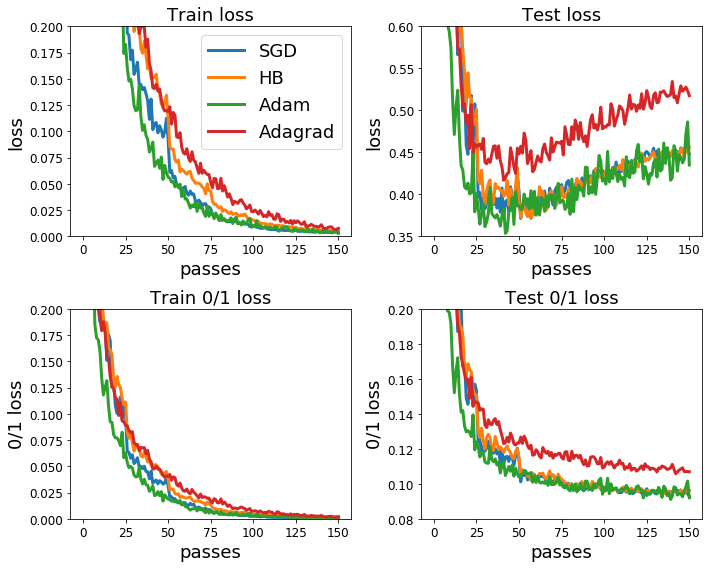

In [15]:
plot_helper.plot_optimization_all()

## Batch Normalization
Batch Normalization (batch norm) introduced by [Ioffe and Szegedy 2015](https://arxiv.org/abs/1502.03167), is a technique that centers and normalizes each feature at every level of representation for *each mini-batch* during training.
Empirically, although without conclusive scientific evidence, batch norm has been 
reported to stabilize the gradient (less exploding or vanishing values), in this sense it can be seen as pre-conditioning of the optimization problem. Batch-normalized models have also been reported to overfit less, and as a result, have become overwhelmingly popular in the deep learning community.

Although the community does not have a complete understanding of batch norm, 
recent work has aimed to improve our understanding, e.g., [Ren et al 2016](https://arxiv.org/abs/1611.04520), [Kohler et al 2018](https://arxiv.org/abs/1805.10694), to name a few. 
Following [Santurkar et al 2018](https://arxiv.org/abs/1805.11604), we shall illustrate how models with batch norm are effectively smoother (measured experimentally via a heuristic measure of smoothness)
than equivalent models without batch norm.

### Standardization in linear regression
In linear regression, it is common practice to preprocess the data by centering, decorrelating and normalizing the data. This operation is called *whitening* as the resulting data is reduced to a white noise, see e.g. [this course](https://www.projectrhea.org/rhea/index.php/ECE662_Whitening_and_Coloring_Transforms_S14_MH) for more details on this operation. In practice decorrelating the data requires the inversion of its covariance matrix which is often costly, so one simply *standardizes* the data by subtracting its mean and normalizing the variance of each feature. 

**Exercise :**
 
For a set of points $x_1,\ldots, x_n \in \mathbb{R}^d$, represented by the matrix $X = (x_1,\ldots, x_n) \in \mathbb{R}^{d \times n} $, derive analytically the standardization operation that, given the matrix $X$ as input, outputs a standardized matrix $\widehat X = S(X)$

### Batch normalization idea:
The idea of batch normalization is to standardize the inputs of each layer by using the statistics of a mini-batch (instead of the entire batch), this would reduce the smoothness constant of each layer and stabilize the optimization procedure. 

Formally, consider a neural network, that takes as input for training mini-batches of points $X = (x_{i_1},\ldots,x_{i_m})$. The output of the $t^{th}$ layer is a batch denoted $X^t = (x^t_{i_1}, \ldots, x_{i_1}^t)$ whose dimension depends on the layer. Batch normalization amounts to add after the $t^{th}$ layer, the additional non-linear operation of standardization defined above and add scaling parameters i.e. adding the stage
$$
X^{t+1/2} = \operatorname{diag}(a) S(X) + b
$$
where parameters $a$ and $b$ are additional parameters to learn in the resulting network.

At test time, the network does not use batches, the mean and variances used in the batch normalization stage are then the ones estimated along the mini-batches used in the train through an average.

### Experiments
We now consider the performance of the batch normalization operation on a simple network for the same image classification task on the same small CIFAR data set, we simply augment the batch size for this experiment. We also use the same loss (cross-entropy).

In [6]:
# Dataloaders
BATCH_SIZE=128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Use cross entropy loss
loss_fn = nn.CrossEntropyLoss() 

#### Define Neural Networks
Next, let us define our neural networks. We shall use a simple convolutional neural network with two convolutional layers and one fully connected hidden layer. We shall also use the same network with batch norm inserted after the convolutions and before the pooling.


In [7]:
class Net_noBN(nn.Module):
    """
    Neural network without batch normalization
    """
    def __init__(self):
        super().__init__()
        num_input_channels = 3
        num_channels_1 = 6
        kernel_size = 5
        num_channels_2 = 16
        fc_size = 120
        mp_ksize = mp_stride = 2 # max pool parameters
        output_size = 10
        conv_out_size = num_channels_2 * kernel_size * kernel_size
        
        self.conv1 = nn.Conv2d(num_input_channels, num_channels_1, kernel_size)
        self.pool = nn.MaxPool2d(mp_ksize, mp_stride)
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size)
        self.fc1 = nn.Linear(conv_out_size, fc_size)
        self.fc2 = nn.Linear(fc_size, output_size)
 
    def forward(self, x):
        bat_size = x.shape[0]
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(bat_size, -1)
        x = relu(self.fc1(x))
        x = dropout(x, training=self.training)
        x = self.fc2(x)
        return x


class Net_BN(nn.Module):
    """
    Neural network with batch normalization
    """
    def __init__(self):
        super().__init__()
        num_input_channels = 3
        num_channels_1 = 6
        kernel_size = 5
        num_channels_2 = 16
        fc_size = 120
        mp_ksize = mp_stride = 2 # max pool parameters
        output_size = 10
        conv_out_size = num_channels_2 * kernel_size * kernel_size
        
        self.conv1 = nn.Conv2d(num_input_channels, num_channels_1, kernel_size)
        self.bn1 = nn.BactchNorm2d(num_channels_1)
        self.pool = nn.MaxPool2d(mp_ksize, mp_stride)
        self.conv2 = nn.Conv2d(num_channels_1, num_channels_2, kernel_size)
        self.bn2 = nn.BactchNorm2d(num_channels_2)
        self.fc1 = nn.Linear(conv_out_size, fc_size)
        self.fc2 = nn.Linear(fc_size, output_size)

    def forward(self, x):
        bat_size = x.shape[0]
        x = self.pool(relu(self.bn1(self.conv1(x))))
        x = self.pool(relu(self.bn2(self.conv2(x))))
        x = x.view(bat_size, -1)
        x = relu(self.fc1(x))
        x = dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## Optimize the networks and observe "local smoothness"

### Local smoothness

In the strict mathematical sense of the term, 
any neural network $f$ with ReLU activations is not *smooth* as it is not even everywhere differentiable. However, $f$ is locally Lipschitz and is therefore differentiable *almost everywhere*.

We will still use the following local smoothness estimate $\widehat L$ at $w$
$$
\widehat L = \frac{\| \nabla f(w + \Delta w) - \nabla f(w) \|_2}{\|\Delta w\|_2} \,,
$$
where we heuristically choose $\Delta w$ in the direction given by a stochastic gradient.

### Smoothness and optimization

Optimization of smooth functions is controlled by the level of smoothness, 
with smoother functions being easier to optimize. See, for example, 
the accompanying notes.
We hope to get some insights
into how batch norm changes the effective local smoothness of the function, as
measured via the heuristic estimates $\widehat L$.

### Code

The following code will now optimize the neural nets defined earlier (with or without) 
batch normalization to report this estimate of the smoothness. We start with a pre-trained model.

**Exercise :** In function `train` below, fill out the missing steps marked by `TODO`s.

In [10]:
def train(params, net=None):
    """
    This function does the following:
        - Intializes a network, either a pre-trained network or a new network.
        - Defines some utility functions to log performance.
        - Logs smoothness estimates in the course of training.
    """
    # Use pre-trained network if provided, else create a new one.
    if net is None and params.bn == 'bn':
        print('Training with BN')
        net = Net_BN().to(device)
    elif net is None:
        print('Training without BN')
        net = Net_noBN().to(device)
    else:
        print('Fine-tuning pre-trained network')
        net = net.to(device)

    # Use SGD and decay the learning rate by a factor `gamma` every 25 epochs
    optimizer = optim.SGD(net.parameters(), lr=params.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=params.gamma, last_epoch=-1)

    # Utility to evaluate performance
    def evaluate_net():
        net.eval()
        loss, correct, total = 0., 0., 0.
        with torch.no_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                outs = net(images)
                loss += loss_fn(outs, labels).item() * labels.size(0)
                _, pred = torch.max(outs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        return loss/total, correct/total

    # Logging
    print('Epoch\t\tloss\t\taccuracy\tTime\t\teval_time')
    format_str = '{:d}\t\t{:.4f}\t\t{:.4f}\t\t{:.2f}\t\t{:.2f}'
    logs = []
    t2 = time.time()
    l, a = evaluate_net()
    out = [0, l, a, 0, time.time() - t2]
    print(format_str.format(*out))
    logs.append(out)
    curvs = []
    
    # Now, we train
    for epoch in range(params.num_epochs):
        net.train()
        scheduler.step()

        t1 = time.time()

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

             # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
             
            # log effective smoothness: 
            # This operation uses the function compute_curv in curv.py to estimate
            # effective smoothness
            if i % 33 == 0:
                c = compute_curv(net, loss_fn, optimizer.param_groups[0]['lr'] / 2,
                                 trainloader)
                curvs.append([ epoch + i / len(trainloader), c[0], c[1]])
           
        # log at the end of epoch
        t2 = time.time()
        l, a = evaluate_net()
        out = [epoch+1, l, a, t2-t1, time.time() - t2]
        print(format_str.format(*out))
        logs.append(out)

    return net, logs, curvs

### Running code
Let us now run the experiments using models pre-trained for 50 epochs on the CIFAR-10 dataset. First, we shall use the network with batch norm and then use the network without batch norm. We shall visualize results based on 5 epochs.

__NOTE__: the cell below should take ~5 min to run.

In [11]:
# set random seed for reproducibility
torch.manual_seed(372018) 
params = Namespace()
params.num_epochs = 5

t1 = time.time()

## Run with batch norm
params.lr = 2e-2 # learning rate
params.gamma = 0.2 # step-size decay parameter
params.bn = 'bn'
# Load pre-trained network
with open('data/bn.p', 'rb') as fp:
    net = pickle.load(fp)[0]
# Run with pre-trained network
w1, logs1, curvs1 = train(params, net)

## Run without batch norm
params.lr = 1e-2 # learning rate
params.gamma = 0.2 # step-size decay parameter
params.bn = 'no_bn'
# Load pre-trained network
with open('data/no_bn.p', 'rb') as fp:
    net = pickle.load(fp)[0]
# Run with pre-trained network
w2, logs2, curvs2 = train(params, net)

print('total time:', time.time() - t1)

Fine-tuning pre-trained network
Epoch		loss		accuracy	Time		eval_time
0		0.7717		0.7331		0.00		3.18
1		0.7809		0.7272		38.10		3.92
2		0.7453		0.7407		34.63		2.96


KeyboardInterrupt: 

### Visualizing results
Let us plot the effective local smoothness for both networks with and without batch norm.

As we shall see, batch norm leads to smaller values of $\widehat L$, i.e., more smoothness which means that potentially larger learning rates could be used. Moreover, $\widehat L$ obtained is also more stable for batch norm as the optimization proceeds.

In [ ]:
plot_helper.plot_batch_norm(curvs1, curvs2)

### Full Results
Here are results from the same code run for 150 epochs, starting from a random intialization over 5 random runs. The shaded regions represent one standard deviation across the random runs.

In [ ]:
plot_helper.plot_batch_norm_all()

In [12]:
torch.__version__

'0.4.0'